In [1]:
# Import necessary libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import random
import time
import os

# Adjust the options for viewing charts in notebook
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':100})

# Adjust options for viewing dataframes in notebook
pd.set_option('display.width', 2000)

In [2]:
# Function for reading a data file
def read_data(name):
    df = pd.read_csv('./../../data/clean_data/' + name + '.csv')
    df['Hour'] = pd.to_datetime(df['Hour'])
    df = df.set_index('Hour')
    df.index.freq = 'h'
    return df

In [3]:
# Function for locating random batches from dataset

## Take dataset, length of training data, length of testing data and number of batches to extract as parameters
## Find a number of digits that represent the indices of the original dataset, where the extracted batches will start from
## Each subset dataset will not intersect with other datasets
def extract_batches(df, train_length, test_length, batch_count):
    start = time.time()
    random_int_list = []
    m = 0
    random.seed(1)
    data_end = len(df)
    new_data_size = train_length + test_length
    while m < batch_count:
        random_int = random.randint(0, data_end - new_data_size)
        q = 0
        for i in random_int_list:
            # Make sure batches do not overlap
            if i + new_data_size <= random_int or random_int + new_data_size <= i:
                pass
            else:
                q = 1
                # In case solution does not exist with current combination
                if time.time() - start > 2:
                    print('Restarted')
                    random_int_list = []
                    start = time.time()
                    m = 0

        # Prevent batches with 0 energy
        if df['Energy'][random_int: random_int + train_length].sum() == 0:
            q = 1
        elif df['Energy'][random_int +  train_length: random_int + new_data_size].sum() == 0:
            q = 1

        # Record the position of the batch
        if q == 0:
            random_int_list.append(random_int)
            m = m + 1
    return random_int_list

In [4]:
# Function for plotting training, predicted and actual values
def plot(train, predictions, actual):
    plt.plot(predictions, label='forecast', color='b')
    plt.plot(train, label='train', color='orange')
    plt.plot(actual, label='actual', color='r')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [5]:
# Function for forecasting using random values in the range of one standard deviation from the mean
def predict_random(train, test_steps):
    AVG = np.mean(train)
    STD = np.std(train, ddof=1)
    forecast = []

    i = 0
    # Allow for reproducible results
    random.seed(1)
    while i < test_steps:
        random_int = random.randint(np.round(AVG - STD), np.round(AVG + STD))
        forecast.append(random_int)
        i = i + 1
    forecast = [max(n, 0) for n in forecast]
    return forecast

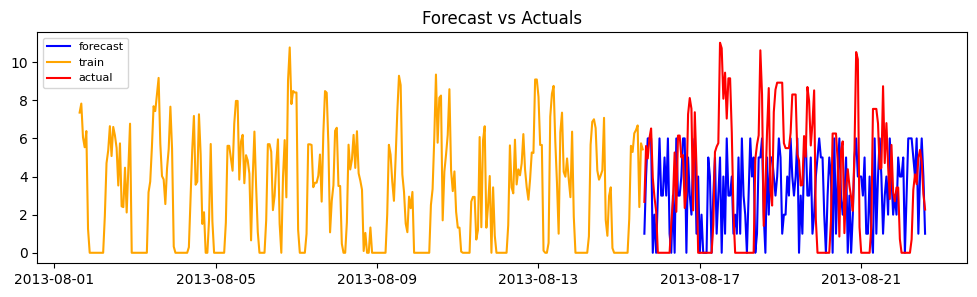

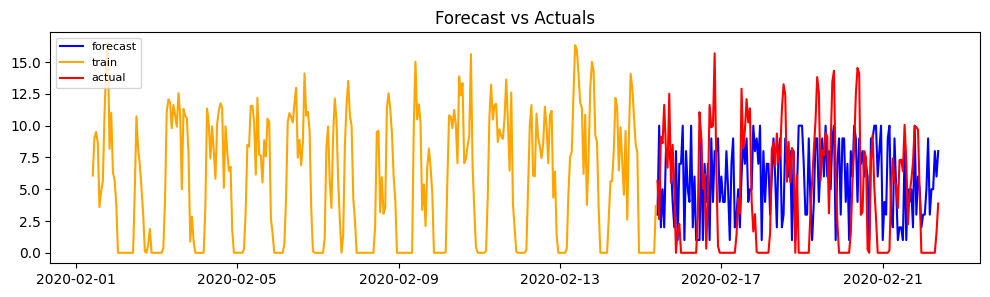

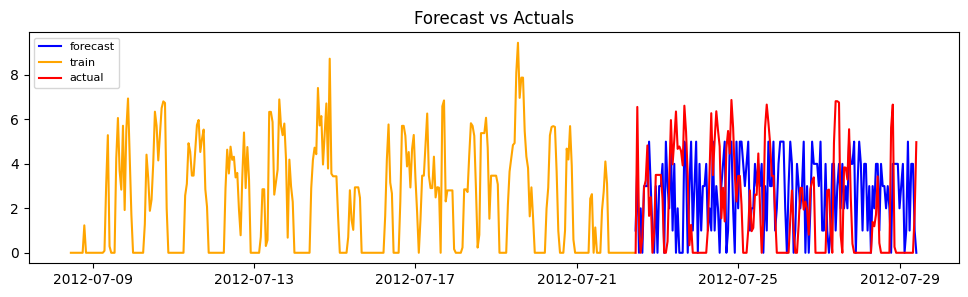

,Batch 1,Batch 2,Batch 3,Average
Time (s),0.001,0.001,0.001,0.001


In [6]:
# Testing random baseline on HAMILTON.txt with 3 random batches and plotting
df = read_data('HAMILTON')
train_length = 336 # 14 days
test_length = 168  # 7 days
start_index_list = extract_batches(df, train_length, test_length, 3)

# Create the empty results dataframe to hold the results
row_headers = ['Time (s)']
df_results = pd.DataFrame()

for start_index in start_index_list:
    train = df[start_index: start_index + train_length]
    test = df[start_index + train_length: start_index + train_length + test_length]

    # Start the timer
    start = time.time()

    predictions = predict_random(train['Energy'], test_length)
    predictions = pd.Series(predictions, index=test.index)

    # End the timer
    time_value = np.round(time.time() - start, 3)

    # Append the batch results to the results dataframe
    row = [time_value]
    df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    plot(train['Energy'], predictions, test['Energy'])

# Calculate the average of each column
average_value_list = np.round(df_results.mean(), 3).tolist()

# Append the average to each column
df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)

# Reformat the results dataframe
df_results = df_results.transpose()
df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Average']

# Display results
display(df_results)

In [7]:
# Function for running the execution time tests and collecting the results

def analyse(df, train_length, test_length, batch_count):
    # Find appropriate (random) indices for batches to prevent overlap
    start_index_list = extract_batches(df, train_length, test_length, batch_count)

    # Create the empty results dataframe to hold the results
    row_headers = ['Energy (kWh)', 'Time (s)']
    df_results = pd.DataFrame()

    # For each batch, get testing and training data and make predictions
    for start_index in start_index_list:
        train = df[start_index: start_index + train_length]
        test = df[start_index + train_length: start_index + train_length + test_length]

        # Start the timer
        start = time.time()

        predictions = predict_random(train['Energy'], test_length)

        # End the timer
        time_value = np.round(time.time() - start, 3)

        # Calculate total energy demand in batch
        demand_value = np.round(test['Energy'].sum(), 3)

        # Append the batch results to the results dataframe
        row = [demand_value, time_value]
        df_results = pd.concat([df_results, pd.DataFrame([row], columns=row_headers)], ignore_index=True)

    # Calculate the average of each column
    average_value_list = np.round(df_results.mean(), 3).tolist()
    # Calculate the minimum of each column
    min_value_list = np.round(df_results.min(), 3).tolist()
    # Calculate the maximum of each column
    max_value_list = np.round(df_results.max(), 3).tolist()
    # Calculate the standard deviation of each column
    stddev_value_list = np.round(df_results.std(), 3).tolist()
 
    # Append the average to each column
    df_results = pd.concat([df_results, pd.DataFrame([average_value_list], columns=row_headers)], ignore_index=True)
    # Append the minimum to each column
    df_results = pd.concat([df_results, pd.DataFrame([min_value_list], columns=row_headers)], ignore_index=True)
    # Append the maximum to each column
    df_results = pd.concat([df_results, pd.DataFrame([max_value_list], columns=row_headers)], ignore_index=True)
    # Append the standard deviation to each column
    df_results = pd.concat([df_results, pd.DataFrame([stddev_value_list], columns=row_headers)], ignore_index=True)

    # Reformat the results dataframe
    df_results = df_results.transpose()
    df_results.columns = ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5', 'Batch 6', 'Batch 7', 'Batch 8', 'Batch 9', 'Batch 10',
                            'Average', 'Minimum', 'Maximum', 'Std. Dev.']
    
    # Display results
    display(df_results)

    return df_results

In [8]:
# Conducting extensive batch testing of execution time on different forecast periods and training period lengths, with 10 random batches each
def main(name):
    # Make the directory for the results
    if os.path.isdir('../../data/execution_time_results/BASELINE'):
        pass
    else:
        os.makedirs('../../data/execution_time_results/BASELINE')

    print('-- Performance metric testing --')
    df = read_data(name)
    print('\n{}'.format(name))
    file_name = '../../data/execution_time_results/BASELINE/' + name + '_BASELINE.xlsx'

    # Write the tables to appropriate xlsx files
    with pd.ExcelWriter(file_name, mode='w', engine='xlsxwriter') as writer:

        # Run the tests for each training type
        q = 0
        while q < 3:
            # Modify execution parameters if needed
            test_length = [336, 168, 72, 24]                               # Hours in testing set
            batch_count = [10, 10, 10, 10]                                 # Batch count
            start_row = [1, 5, 9, 13]                                     # Row position in xlsx file to write results in
            durations = ['14 Days', '7 Days', '3 Days', '1 Day']           # Durations of batches, used for titles

            if q == 0:
                # 1. Two weeks training data
                print('-- Two Weeks Training Data --')
                pd.DataFrame(['14 Days Training']).to_excel(writer, sheet_name=name, startrow=0, header=None, index=None)

                train_length = [336, 336, 336, 336]                        # Hours in training set
                start_col = 0                                              # Column position in xlsx file to write results in
            elif q == 1:
                # 2. 75:25 Ratio of training to testing data
                print('-- 75:25 Ratio of Training to Testing Data --')
                pd.DataFrame(['Training:Testing = 75:25']).to_excel(writer, sheet_name=name, startrow=0, startcol=16, header=None, index=None)

                train_length = [1008, 504, 216, 72]                        # Hours in training set
                start_col = 16                                             # Column position in xlsx file to write results in
            else:
                # 3. 50:50 Ratio of training to testing data
                print('-- 50:50 Ratio of Training to Testing Data --')
                pd.DataFrame(['Training:Testing = 50:50']).to_excel(writer, sheet_name=name, startrow=0, startcol=32, header=None, index=None)

                train_length = [336, 168, 72, 24]                          # Hours in training set
                start_col = 32                                             # Column position in xlsx file to write results in

            all_results_list = []

            i = 0
            while i < len(test_length):
                print('{} Ahead Forecast:'.format(durations[i]))

                # Run set of batches and collect results
                df_results = analyse(df, train_length[i], test_length[i], batch_count[i])
                all_results_list.append(df_results)

                # Write results to xlsx file
                df_results.to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                pd.DataFrame(['{} Forecast'.format(durations[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                i = i + 1

            # Create summary dataframes
            df_summary_avg = pd.concat([df['Average'] for df in all_results_list], axis="columns")
            df_summary_min = pd.concat([df['Minimum'] for df in all_results_list], axis="columns")
            df_summary_max = pd.concat([df['Maximum'] for df in all_results_list], axis="columns")
            df_summary_stddev = pd.concat([df['Std. Dev.'] for df in all_results_list], axis="columns")

            for i in [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]:
                i.columns = durations

            # Modify summary parameters if needed
            start_row = [17, 21, 25, 29]                                                        # Row position in xlsx file to write results in
            summary_name = [df_summary_avg, df_summary_min, df_summary_max, df_summary_stddev]  # Summary reference list
            print_title = ['Average', 'Minimum', 'Maximum', 'Standard Deviation']               # Title for printing results
            summary_title = ['Avg.', 'Min.', 'Max.', 'Std.Dev.']                                # Dataframe title in xlsx file

            i = 0
            while i < 4:
                print('{} Values Summary - {}:'.format(print_title[i], name))

                # Display summary
                display(summary_name[i])

                # Write summary to xlsx file
                summary_name[i].to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col)
                pd.DataFrame(['{} Forecast'.format(summary_title[i])]).to_excel(writer, sheet_name=name, startrow=start_row[i], startcol=start_col, header=None, index=None)
                i = i + 1

            q = q + 1

        # Adjust the columns' widths
        worksheet = writer.sheets[name]
        workbook = writer.book
        worksheet.set_column(0, 0, 15)
        worksheet.set_column(16, 16, 20)
        worksheet.set_column(32, 32, 20)
        # Adjust cell formating
        format1 = workbook.add_format({'bg_color': '#EDEDED', 'border': 1})
        worksheet.conditional_format(0, 0, 39, 46, {'type': 'no_blanks', 'format': format1})

In [9]:
main('WEBSTER')

-- Performance metric testing --

WEBSTER
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.190,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
Time (s),0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1642.875,1378.006,1231.265,1109.232,1947.639,1272.497,1947.678,1027.345,179.855,1343.281,1307.967,179.855,1947.678,509.329
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),674.331,689.480,574.627,548.452,825.515,593.708,839.197,570.248,62.273,737.272,611.51,62.273,839.197,219.215
Time (s),0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.000,0.001,0.000,0.00,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),229.586,163.234,271.363,245.623,111.703,179.943,227.082,167.094,6.218,255.276,185.712,6.218,271.363,80.265
Time (s),0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.001


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1307.967,611.51,185.712
Time (s),0.002,0.001,0.00,0.000


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,179.855,62.273,6.218
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,1947.678,839.197,271.363
Time (s),0.003,0.001,0.001,0.001


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,509.329,219.215,80.265
Time (s),0.000,0.000,0.001,0.001


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),512.484,2623.430,2453.461,2014.774,4238.914,2384.657,1061.268,2041.756,745.308,3793.892,2186.994,512.484,4238.914,1215.342
Time (s),0.002,0.002,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1682.311,1232.184,1202.892,1047.740,2022.188,1408.102,1965.443,1121.042,442.457,961.306,1308.566,442.457,2022.188,480.887
Time (s),0.001,0.001,0.000,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.000,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),782.450,555.498,505.135,631.427,951.196,391.551,942.332,445.810,126.156,484.981,581.654,126.156,951.196,255.474
Time (s),0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.000,0.001,0.000


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),296.216,60.465,172.158,147.807,277.709,82.775,310.803,103.316,8.336,255.917,171.55,8.336,310.803,108.218
Time (s),0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.001,0.000


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2186.994,1308.566,581.654,171.55
Time (s),0.002,0.001,0.001,0.00


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),512.484,442.457,126.156,8.336
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4238.914,2022.188,951.196,310.803
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1215.342,480.887,255.474,108.218
Time (s),0.000,0.000,0.000,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3325.185,2610.190,2434.157,2156.972,3969.827,2680.599,3913.121,2148.387,622.312,1773.907,2563.466,622.312,3969.827,1007.818
Time (s),0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1620.515,1218.634,1444.036,1071.478,1985.305,945.207,2026.609,1192.549,401.147,1137.343,1304.282,401.147,2026.609,488.94
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.002,0.00


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),854.792,257.11,525.899,505.714,845.222,341.503,1022.777,455.865,44.450,474.455,532.779,44.45,1022.777,298.618
Time (s),0.001,0.00,0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.000,0.00,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),58.975,100.873,206.136,228.316,342.823,163.299,179.004,202.791,85.068,212.942,178.023,58.975,342.823,82.526
Time (s),0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000


Average Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2563.466,1304.282,532.779,178.023
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),622.312,401.147,44.45,58.975
Time (s),0.002,0.001,0.00,0.000


Maximum Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3969.827,2026.609,1022.777,342.823
Time (s),0.003,0.002,0.001,0.001


Standard Deviation Values Summary - WEBSTER:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1007.818,488.94,298.618,82.526
Time (s),0.000,0.00,0.001,0.000


In [10]:
main('CAMBRIDGE')

-- Performance metric testing --

CAMBRIDGE
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
Time (s),0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1444.492,1369.866,928.969,900.689,984.465,1368.427,970.418,633.994,606.399,776.700,998.442,606.399,1444.492,302.739
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),358.073,650.140,419.428,466.132,402.897,709.202,353.539,359.67,223.54,429.462,437.208,223.54,709.202,144.006
Time (s),0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.00,0.00,0.001,0.000,0.00,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.485,216.404,162.154,175.727,113.535,193.151,80.726,132.508,65.55,112.353,137.759,65.55,216.404,48.497
Time (s),0.001,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.001,0.000


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,998.442,437.208,137.759
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,606.399,223.54,65.55
Time (s),0.001,0.001,0.00,0.00


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1444.492,709.202,216.404
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,302.739,144.006,48.497
Time (s),0.000,0.000,0.001,0.000


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.751,2033.177,1851.882,2289.041,1817.842,1349.984,1387.975,1342.536,1569.538,3212.624,1746.935,614.751,3212.624,691.486
Time (s),0.003,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.001,0.003,0.001


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1654.364,1102.118,952.120,946.744,928.296,1157.348,1015.897,642.759,621.408,704.220,972.527,621.408,1654.364,302.727
Time (s),0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.000,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),918.300,390.429,333.129,264.730,426.859,213.789,450.542,304.856,175.958,225.563,370.416,175.958,918.300,213.534
Time (s),0.001,0.001,0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.001,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),331.914,91.58,93.949,163.655,114.851,46.17,147.9,81.608,105.256,96.898,127.378,46.17,331.914,79.047
Time (s),0.000,0.00,0.000,0.000,0.000,0.00,0.0,0.001,0.000,0.001,0.000,0.00,0.001,0.000


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1746.935,972.527,370.416,127.378
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),614.751,621.408,175.958,46.17
Time (s),0.001,0.000,0.000,0.00


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3212.624,1654.364,918.300,331.914
Time (s),0.003,0.002,0.001,0.001


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),691.486,302.727,213.534,79.047
Time (s),0.001,0.000,0.001,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),3098.857,2471.984,1881.089,1847.433,1912.761,2525.775,1986.315,1276.753,1227.807,1406.213,1963.499,1227.807,3098.857,597.266
Time (s),0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1714.224,779.583,946.577,643.208,856.199,690.584,921.932,798.814,504.007,621.705,847.683,504.007,1714.224,334.822
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.003,0.001,0.000,0.003,0.001


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),888.729,245.842,273.891,400.955,404.986,262.901,469.895,235.760,320.806,187.723,369.149,187.723,888.729,203.038
Time (s),0.000,0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),274.461,61.458,146.791,154.864,140.382,196.849,42.685,161.386,60.771,115.513,135.516,42.685,274.461,70.199
Time (s),0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000


Average Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1963.499,847.683,369.149,135.516
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1227.807,504.007,187.723,42.685
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3098.857,1714.224,888.729,274.461
Time (s),0.002,0.003,0.001,0.001


Standard Deviation Values Summary - CAMBRIDGE:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),597.266,334.822,203.038,70.199
Time (s),0.000,0.001,0.001,0.000


In [11]:
main('MPL')

-- Performance metric testing --

MPL
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.760,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),511.493,673.730,579.509,888.775,607.683,1521.253,108.595,614.179,1373.388,735.485,761.409,108.595,1521.253,414.123
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),254.306,262.123,256.38,318.993,239.791,647.548,58.685,287.509,553.951,279.410,315.87,58.685,647.548,166.995
Time (s),0.001,0.000,0.00,0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.00,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),93.038,88.064,88.879,133.649,89.857,249.203,2.349,112.075,207.702,103.608,116.842,2.349,249.203,68.531
Time (s),0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.001,0.001


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,761.409,315.87,116.842
Time (s),0.002,0.001,0.00,0.000


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,108.595,58.685,2.349
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1521.253,647.548,249.203
Time (s),0.003,0.001,0.001,0.001


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,414.123,166.995,68.531
Time (s),0.000,0.000,0.001,0.001


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),250.184,369.717,1055.324,1491.290,1237.810,3052.889,414.178,1303.993,764.207,1358.243,1129.784,250.184,3052.889,811.440
Time (s),0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.001,0.002,0.001,0.003,0.001


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),756.301,684.030,724.748,687.017,632.536,1408.437,85.769,633.630,1256.622,750.467,761.956,85.769,1408.437,359.987
Time (s),0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),217.072,338.499,174.794,384.358,224.724,564.477,65.751,230.083,508.980,267.065,297.58,65.751,564.477,153.198
Time (s),0.000,0.000,0.000,0.000,0.002,0.001,0.000,0.000,0.001,0.001,0.00,0.000,0.002,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),94.542,124.964,42.11,106.791,65.512,157.594,65.901,280.144,93.208,22.979,105.374,22.979,280.144,72.924
Time (s),0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1129.784,761.956,297.58,105.374
Time (s),0.002,0.001,0.00,0.000


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),250.184,85.769,65.751,22.979
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3052.889,1408.437,564.477,280.144
Time (s),0.003,0.001,0.002,0.001


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),811.440,359.987,153.198,72.924
Time (s),0.001,0.000,0.001,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1267.793,1357.760,1304.257,1575.792,1240.219,2929.690,194.364,1247.809,2630.010,1485.952,1523.365,194.364,2929.690,765.191
Time (s),0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.002,0.002,0.001,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),527.492,875.126,366.614,827.556,596.389,1468.923,92.626,448.117,1212.038,704.425,711.931,92.626,1468.923,405.921
Time (s),0.001,0.001,0.000,0.002,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.000,0.002,0.001


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),231.971,338.742,154.335,317.732,226.719,486.703,218.418,664.265,303.184,124.067,306.614,124.067,664.265,162.535
Time (s),0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.001,0.000


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),113.512,97.638,60.083,76.293,113.553,145.788,64.007,242.127,67.668,65.646,104.632,60.083,242.127,55.907
Time (s),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.000


Average Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.365,711.931,306.614,104.632
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),194.364,92.626,124.067,60.083
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2929.690,1468.923,664.265,242.127
Time (s),0.003,0.002,0.001,0.001


Standard Deviation Values Summary - MPL:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),765.191,405.921,162.535,55.907
Time (s),0.000,0.001,0.000,0.000


In [12]:
main('RINCONADA LIB')

-- Performance metric testing --

RINCONADA LIB
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),471.782,428.887,380.735,381.345,341.868,1122.184,360.284,1102.759,345.335,321.891,525.707,321.891,1122.184,312.365
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),312.659,226.637,145.732,228.451,124.2,449.338,111.564,498.917,125.843,160.059,238.34,111.564,498.917,139.299
Time (s),0.000,0.001,0.001,0.001,0.0,0.000,0.001,0.000,0.000,0.001,0.00,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.522,63.175,21.875,61.345,49.208,153.676,48.601,196.143,49.138,85.276,77.796,21.875,196.143,54.489
Time (s),0.001,0.000,0.001,0.000,0.001,0.001,0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.001


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,525.707,238.34,77.796
Time (s),0.002,0.001,0.00,0.001


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,321.891,111.564,21.875
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1122.184,498.917,196.143
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,312.365,139.299,54.489
Time (s),0.000,0.000,0.001,0.001


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),450.827,1279.165,917.640,539.919,831.107,2257.982,910.708,1456.058,642.601,1680.822,1096.683,450.827,2257.982,569.87
Time (s),0.002,0.003,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.003,0.00


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),472.587,377.623,526.628,213.342,287.926,1135.132,448.047,1226.086,389.848,669.564,574.678,213.342,1226.086,343.51
Time (s),0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.00


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),70.735,237.027,167.587,198.014,84.149,412.5,101.323,404.921,346.946,126.274,214.948,70.735,412.500,130.910
Time (s),0.001,0.000,0.000,0.001,0.001,0.0,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),38.6,55.619,28.035,81.869,11.981,116.475,91.594,132.153,116.45,47.923,72.07,11.981,132.153,41.57
Time (s),0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.001,0.00,0.000,0.001,0.00


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1096.683,574.678,214.948,72.07
Time (s),0.002,0.001,0.000,0.00


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),450.827,213.342,70.735,11.981
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2257.982,1226.086,412.500,132.153
Time (s),0.003,0.001,0.001,0.001


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),569.87,343.51,130.910,41.57
Time (s),0.00,0.00,0.001,0.00


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),944.369,806.510,907.363,594.687,629.794,2257.317,808.331,2328.845,735.183,1174.872,1118.727,594.687,2328.845,640.625
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),404.187,549.226,395.254,337.279,281.411,1061.526,208.546,1085.027,563.583,341.123,522.716,208.546,1085.027,309.744
Time (s),0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.002,0.001,0.001,0.000,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.608,220.22,133.578,146.556,242.090,352.598,267.100,481.181,261.002,155.876,236.281,102.608,481.181,114.644
Time (s),0.001,0.00,0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),49.019,101.869,25.196,84.321,15.759,135.812,66.19,160.829,65.484,23.584,72.806,15.759,160.829,48.651
Time (s),0.000,0.001,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.001,0.000


Average Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1118.727,522.716,236.281,72.806
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),594.687,208.546,102.608,15.759
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2328.845,1085.027,481.181,160.829
Time (s),0.002,0.002,0.001,0.001


Standard Deviation Values Summary - RINCONADA LIB:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),640.625,309.744,114.644,48.651
Time (s),0.000,0.000,0.001,0.000


In [13]:
main('TED THOMPSON')

-- Performance metric testing --

TED THOMPSON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.001,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),970.861,771.519,738.332,794.073,570.688,1067.644,517.082,452.662,358.297,747.915,698.907,358.297,1067.644,224.688
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),235.229,359.565,349.916,518.218,231.039,545.294,197.458,247.695,64.493,459.041,320.795,64.493,545.294,153.646
Time (s),0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.001,0.001,0.001,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),63.065,130.288,100.346,235.363,40.823,162.825,59.193,53.004,37.456,184.273,106.664,37.456,235.363,68.716
Time (s),0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,698.907,320.795,106.664
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,358.297,64.493,37.456
Time (s),0.001,0.001,0.000,0.000


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1067.644,545.294,235.363
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,224.688,153.646,68.716
Time (s),0.000,0.000,0.001,0.000


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),513.840,1891.446,1772.255,1456.752,1243.755,821.866,677.976,662.064,805.959,2104.862,1195.078,513.840,2104.862,579.549
Time (s),0.002,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.002,0.001,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1442.154,860.315,1104.521,761.286,571.606,752.196,605.785,476.220,317.792,318.232,721.011,317.792,1442.154,351.104
Time (s),0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),648.027,273.132,181.096,421.898,252.002,94.214,269.887,125.912,165.758,277.051,270.898,94.214,648.027,162.202
Time (s),0.001,0.001,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.001,0.001,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),246.53,63.163,23.06,122.899,102.635,77.208,84.491,23.893,50.956,90.152,88.499,23.06,246.530,64.127
Time (s),0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.00,0.001,0.000


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1195.078,721.011,270.898,88.499
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),513.840,317.792,94.214,23.06
Time (s),0.001,0.001,0.000,0.00


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2104.862,1442.154,648.027,246.530
Time (s),0.003,0.002,0.001,0.001


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),579.549,351.104,162.202,64.127
Time (s),0.000,0.000,0.001,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),2413.015,1631.835,1842.853,1555.359,1142.294,1819.840,1122.867,928.882,676.089,568.574,1370.161,568.574,2413.015,581.955
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1323.138,695.089,539.595,821.864,556.910,549.532,598.448,473.608,340.996,569.868,646.905,340.996,1323.138,268.993
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),733.07,169.574,236.138,205.282,287.685,400.474,252.870,158.561,175.76,167.391,278.68,158.561,733.070,175.929
Time (s),0.00,0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.00,0.001,0.00,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),151.807,112.732,125.255,218.35,89.112,166.974,53.116,68.552,19.109,111.519,111.653,19.109,218.350,58.309
Time (s),0.000,0.000,0.000,0.00,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.000


Average Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1370.161,646.905,278.68,111.653
Time (s),0.002,0.001,0.00,0.000


Minimum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),568.574,340.996,158.561,19.109
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),2413.015,1323.138,733.070,218.350
Time (s),0.003,0.001,0.001,0.001


Standard Deviation Values Summary - TED THOMPSON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),581.955,268.993,175.929,58.309
Time (s),0.000,0.000,0.001,0.000


In [14]:
main('HAMILTON')

-- Performance metric testing --

HAMILTON
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),637.051,761.709,344.991,671.717,560.723,1076.064,725.763,779.940,811.403,619.989,698.935,344.991,1076.064,188.938
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.610,298.344,193.884,245.634,212.121,405.165,330.104,388.036,318.491,310.982,294.237,193.884,405.165,71.052
Time (s),0.001,0.001,0.000,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.000,0.001,0.000


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),68.919,88.089,59.76,73.865,55.342,156.473,123.574,117.366,58.312,96.872,89.857,55.342,156.473,33.615
Time (s),0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,698.935,294.237,89.857
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,344.991,193.884,55.342
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1076.064,405.165,156.473
Time (s),0.002,0.002,0.001,0.000


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,188.938,71.052,33.615
Time (s),0.000,0.000,0.000,0.000


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1189.640,697.222,848.760,1444.027,1179.916,1690.437,1405.346,1576.637,1793.986,1402.654,1322.863,697.222,1793.986,350.191
Time (s),0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),349.417,847.221,391.557,555.752,527.663,806.170,722.728,743.141,838.858,643.016,642.552,349.417,847.221,180.556
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),239.225,468.542,220.508,280.369,247.814,256.015,282.127,326.875,461.495,242.808,302.578,220.508,468.542,90.547
Time (s),0.000,0.001,0.001,0.000,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),66.462,139.88,59.297,85.0,68.223,62.441,71.006,106.698,154.709,61.754,87.547,59.297,154.709,34.654
Time (s),0.000,0.00,0.000,0.0,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1322.863,642.552,302.578,87.547
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),697.222,349.417,220.508,59.297
Time (s),0.001,0.001,0.000,0.000


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1793.986,847.221,468.542,154.709
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),350.191,180.556,90.547,34.654
Time (s),0.000,0.000,0.001,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),986.468,1608.929,736.548,1227.468,1088.386,1882.234,1448.491,1523.081,1650.261,1263.005,1341.487,736.548,1882.234,346.235
Time (s),0.002,0.002,0.001,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),490.082,1001.922,373.149,716.824,566.621,702.232,775.128,742.553,960.058,711.780,704.035,373.149,1001.922,192.986
Time (s),0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.000,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),252.545,421.496,173.693,266.349,253.653,181.465,264.223,338.573,410.377,318.516,288.089,173.693,421.496,84.441
Time (s),0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),73.361,90.609,54.005,49.638,26.187,132.845,131.646,149.135,147.178,109.653,96.426,26.187,149.135,44.201
Time (s),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.000


Average Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1341.487,704.035,288.089,96.426
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),736.548,373.149,173.693,26.187
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1882.234,1001.922,421.496,149.135
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - HAMILTON:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),346.235,192.986,84.441,44.201
Time (s),0.000,0.000,0.001,0.000


In [15]:
main('HIGH')

-- Performance metric testing --

HIGH
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
Time (s),0.002,0.002,0.002,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),309.765,1724.355,134.147,264.254,324.039,1482.749,1230.734,1009.358,1872.151,414.124,876.568,134.147,1872.151,665.58
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.00


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),129.046,693.055,74.853,131.859,131.45,657.002,559.79,398.185,783.302,173.457,373.200,74.853,783.302,277.225
Time (s),0.001,0.001,0.001,0.001,0.00,0.000,0.00,0.001,0.000,0.001,0.001,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),50.622,222.504,17.773,40.253,20.123,218.829,197.477,123.477,201.710,80.012,117.278,17.773,222.504,85.693
Time (s),0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,876.568,373.200,117.278
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,134.147,74.853,17.773
Time (s),0.001,0.001,0.000,0.000


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1872.151,783.302,222.504
Time (s),0.002,0.001,0.001,0.001


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,665.58,277.225,85.693
Time (s),0.000,0.00,0.001,0.000


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),613.881,430.920,158.570,591.953,567.865,3160.782,2274.475,2398.689,4496.677,540.084,1523.390,158.570,4496.677,1471.307
Time (s),0.003,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),324.290,1758.808,157.704,276.220,300.822,1361.048,1021.719,1048.942,1898.210,310.542,845.830,157.704,1898.210,660.994
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),102.562,792.78,84.265,159.197,140.739,398.967,435.927,314.75,908.541,125.776,346.350,84.265,908.541,294.623
Time (s),0.001,0.00,0.000,0.001,0.001,0.001,0.001,0.00,0.001,0.000,0.001,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),31.840,269.354,22.348,43.095,68.378,99.691,89.333,87.826,261.183,37.684,101.073,22.348,269.354,90.498
Time (s),0.001,0.001,0.001,0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.001,0.000,0.001,0.000


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1523.390,845.830,346.350,101.073
Time (s),0.002,0.001,0.001,0.001


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),158.570,157.704,84.265,22.348
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),4496.677,1898.210,908.541,269.354
Time (s),0.003,0.001,0.001,0.001


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1471.307,660.994,294.623,90.498
Time (s),0.000,0.000,0.001,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),634.055,3483.163,291.851,540.474,624.861,2843.797,2252.453,2058.300,3770.361,724.666,1722.398,291.851,3770.361,1323.872
Time (s),0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.003,0.002,0.003,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),269.210,1691.418,178.777,283.892,264.863,1133.605,1158.659,994.529,1880.357,384.924,824.023,178.777,1880.357,634.777
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.000,0.001,0.000,0.001,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),125.870,824.324,73.6,142.802,161.146,339.852,358.488,474.342,834.707,171.086,350.622,73.6,834.707,281.424
Time (s),0.001,0.001,0.0,0.000,0.001,0.001,0.000,0.000,0.001,0.001,0.001,0.0,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),39.966,216.113,40.877,27.775,14.823,108.027,135.15,153.664,355.153,23.035,111.458,14.823,355.153,109.009
Time (s),0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.001,0.000,0.000,0.001,0.000


Average Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1722.398,824.023,350.622,111.458
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),291.851,178.777,73.6,14.823
Time (s),0.002,0.000,0.0,0.000


Maximum Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3770.361,1880.357,834.707,355.153
Time (s),0.003,0.001,0.001,0.001


Standard Deviation Values Summary - HIGH:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1323.872,634.777,281.424,109.009
Time (s),0.000,0.000,0.001,0.000


In [16]:
main('BRYANT')

-- Performance metric testing --

BRYANT
-- Two Weeks Training Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
Time (s),0.002,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.004,0.002,0.002,0.002,0.004,0.001


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),652.196,1325.681,303.567,711.128,646.982,1618.817,1270.905,1315.196,775.881,873.507,949.386,303.567,1618.817,410.475
Time (s),0.001,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),270.309,445.12,158.086,286.600,289.519,697.284,570.375,526.879,266.719,328.385,383.928,158.086,697.284,168.739
Time (s),0.000,0.00,0.000,0.001,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.000


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),116.814,157.466,51.187,72.254,87.342,115.917,174.146,162.927,53.799,135.475,112.733,51.187,174.146,45.191
Time (s),0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.000,0.001,0.001


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,949.386,383.928,112.733
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,303.567,158.086,51.187
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1618.817,697.284,174.146
Time (s),0.004,0.002,0.001,0.001


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,410.475,168.739,45.191
Time (s),0.001,0.000,0.000,0.001


-- 75:25 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),933.391,276.118,752.544,1486.068,1133.005,3382.160,2743.547,2956.873,1761.788,1564.102,1698.960,276.118,3382.160,1022.019
Time (s),0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),657.987,1484.618,311.900,740.947,564.683,1680.730,1372.518,1267.598,846.609,774.010,970.160,311.900,1680.730,449.862
Time (s),0.002,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),271.262,786.841,176.039,350.051,281.090,520.113,443.94,550.53,390.911,379.711,415.049,176.039,786.841,173.288
Time (s),0.001,0.001,0.000,0.000,0.001,0.001,0.00,0.00,0.001,0.001,0.001,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),75.259,286.572,59.863,104.575,71.913,154.303,63.085,267.383,136.936,118.989,133.888,59.863,286.572,81.929
Time (s),0.000,0.000,0.001,0.000,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.000


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1698.960,970.160,415.049,133.888
Time (s),0.002,0.001,0.001,0.000


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),276.118,311.900,176.039,59.863
Time (s),0.002,0.001,0.000,0.000


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3382.160,1680.730,786.841,286.572
Time (s),0.003,0.002,0.001,0.001


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1022.019,449.862,173.288,81.929
Time (s),0.000,0.000,0.001,0.000


-- 50:50 Ratio of Training to Testing Data --
14 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),1310.183,2810.298,615.468,1452.075,1211.665,3299.548,2643.423,2582.795,1622.490,1647.517,1919.546,615.468,3299.548,857.357
Time (s),0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.001,0.001,0.001,0.002,0.001,0.002,0.000


7 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),614.191,1481.103,390.368,812.785,607.705,1357.564,1431.082,1138.378,954.285,924.446,971.191,390.368,1481.103,376.126
Time (s),0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.002,0.001,0.001,0.000,0.002,0.000


3 Days Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),267.547,881.669,157.403,335.637,242.114,293.624,443.890,549.076,405.446,438.606,401.501,157.403,881.669,203.971
Time (s),0.001,0.000,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.001,0.001


1 Day Ahead Forecast:


,Batch 1,Batch 2,Batch 3,Batch 4,Batch 5,Batch 6,Batch 7,Batch 8,Batch 9,Batch 10,Average,Minimum,Maximum,Std. Dev.
Energy (kWh),85.876,82.015,52.842,42.656,42.794,121.656,205.202,285.35,111.558,100.57,113.052,42.656,285.350,77.193
Time (s),0.001,0.000,0.001,0.000,0.001,0.000,0.001,0.00,0.000,0.00,0.000,0.000,0.001,0.001


Average Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),1919.546,971.191,401.501,113.052
Time (s),0.002,0.001,0.000,0.000


Minimum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),615.468,390.368,157.403,42.656
Time (s),0.001,0.000,0.000,0.000


Maximum Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),3299.548,1481.103,881.669,285.350
Time (s),0.002,0.002,0.001,0.001


Standard Deviation Values Summary - BRYANT:


,14 Days,7 Days,3 Days,1 Day
Energy (kWh),857.357,376.126,203.971,77.193
Time (s),0.000,0.000,0.001,0.001
